# Assignment 4 for Course 1MS041
Make         sure you pass the `# ... Test` cells and
 submit your solution notebook in the corresponding assignment on the course website. You can submit multiple times before the deadline         and your highest score will be used.

---
## Assignment 4, PROBLEM 1
Maximum Points = 24


This time the assignment only consists of one problem, but we will do a more comprehensive analysis instead.

Consider the dataset `mammography.mat` that you can download from [http://odds.cs.stonybrook.edu/mammography-dataset/](http://odds.cs.stonybrook.edu/mammography-dataset/). Below you can find the code to load this file into `X` and `Y`, you just need to put the file in your `data` folder. During mammography the doctor would be looking for something called `calcification`, which is calcium deposits in the breast tissue and is used as an indicator of cancer. In this dataset the `X` corresponds to some measurements, there are 6 features. The `Y` is a 0-1 label where 1 represents calcification and 0 does not.

1. [3p] Split the data into three parts, train/test/validation where train is 60% of the data, test is 15% and validation is 25% of the data. Do not do this randomly, I have prepared a shuffling with a fixed seed, this way I can make sure that we all did the same splits. That is [train,test,validation] is the splitting layout.
2. [4p] Train a machine learning model on the training data (you are free to choose it yourself). Hint: you could always try `LogisticRegression`, but for it to work well you would need `StandardScaler` and put everything in a `Pipeline`.
3. [3p] Use the classification report from `Utils` and compute the intervals for precision-recall etc on the test set with `union_bound correction` with 95% confidence.
4. [3p] You are interested in minimizing the average cost of your classifier, but first we must define it:
    * If someone is calcified but classified as not, we say it costs 30 **(this is the worst scenario)** 
    * If someone is not calcified but classified as calcified, we say it costs 5 **(this probably only costs extra investigation)**
    * If someone is calcified but classified as calcified, costs 0 **(We did the right thing, no cost)**
    * If someone is not calcified but classified as not, costs 0 **(We did the right thing, no cost)**.

complete filling the function `cost` to compute the cost of a prediction model under a certain prediction threshold (recall our precision recall lecture and the `predict_proba` function from trained models). What would be the cost of having a model that always classifies someone as not calcified on the test set?

5. [4p] Now, we wish to select the threshold of our classifier that minimizes the cost, we do that by checking say 100 evenly spaced proposal thresholds between 0 and 1, and use our testing data to compute the cost.
6. [4p] With your newly computed threshold value, compute the cost of putting this model in production by computing the cost using the validation data. Also provide a confidence interval of the cost using Hoeffdings inequality with a 95% confidence.
7. [3p] Let $t$ be the threshold you found and $f$ the model you fitted, if we define the random variable
$$
    C = 30(1-1_{f(X)\geq t})Y+5(1-Y)1_{f(X) \geq t}
$$
then $C$ denotes the cost of a randomly chosen patient. In the above we are estimating $\mathbb{E}[C]$ using the empirical mean. However, since the number of calcifications in the population is fairly small and our classifier probably has a fairly high precision for the $0$ class, then $C$ should have fairly small variance. Compute the empirical variance of $C$ on the validation set. What would be the confidence interval if we used Bennett's inequality instead of Hoeffding in point 6 but with the computed empirical variance as our guess for the variance?

In [29]:
import scipy.io as so
import numpy as np
data = so.loadmat('data/mammography.mat')

np.random.seed(0)
shuffle_index = np.arange(0,len(data['X']))
np.random.shuffle(shuffle_index)

X = data['X'][shuffle_index,:]
Y = data['y'][shuffle_index,:].flatten()

In [30]:

# Part 1
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.6)
X_test,X_valid,Y_test,Y_valid = train_test_split(X_test,Y_test,test_size=0.625)


# Split the X,Y into three parts, make sure that the sizes are
# (6709, 6), (1677, 6), (2797, 6), (6709,), (1677,), (2797,)

print(X_train.shape, X_test.shape, X_valid.shape, Y_train.shape, Y_test.shape, Y_valid.shape) 

(6709, 6) (1677, 6) (2797, 6) (6709,) (1677,) (2797,)


In [31]:

# Part 2
# Use X_train,Y_train to train a model from sklearn. Make sure it has the predict_proba function
# for instance LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = Pipeline([('scaler', StandardScaler()), ('logistic regression', LogisticRegression())])
model.fit(X_train,Y_train)
#Y_pred = model.predict_proba(X_test)
print(model.score(X_test,Y_test))


0.9844961240310077


In [32]:

# Part 3

# Compute precision and recall on the test set using 
from Utils import classification_report_interval

y_pred = model.predict(X_test)
print(classification_report_interval(Y_test,y_pred,alpha=0.05))

# Each precision and recall should be a tuple, for instance you can write
# precision0 = (0.9,0.95)

precision0 = (0.94,1.00)
recall0 = (0.95,1.00)
precision1 = (0.22,1.00)
recall1 = (0.03,0.59)

# The code below will check that you supply the proper type
assert(type(precision0) == tuple)
assert(len(precision0) == 2)
assert(type(recall0) == tuple)
assert(len(recall0) == 2)
assert(type(precision1) == tuple)
assert(len(precision1) == 2)
assert(type(recall1) == tuple)
assert(len(recall1) == 2)

            labels           precision             recall

                 0  0.99 : [0.95,1.00] 1.00 : [0.96,1.00]
                 1  0.88 : [0.54,1.00] 0.48 : [0.23,0.73]

          accuracy                                        0.98 : [0.94,1.00]



In [101]:

# Part 4

def cost(model,threshold,X,Y):
    pred_proba = model.predict_proba(X)[:,1]
    predictions = (pred_proba >= threshold)*1
    
    
    # Fill in what is missing to compute the cost and return it
    # Note that we are interested in average cost (cost per person)
    
    cost = 0;
    
    for m,n in enumerate(predictions):
        if n!= Y[m]:
            if n==1 : 
                cost += 5
            else:
                cost += 30
    
    return cost/len(Y)


In [102]:

# Part 4

# Fill in the naive cost of the model that would classify all as non-calcified on the test set
naive_cost = cost(model,0.8,X_test,Y_test)
naive_cost

0.5575432319618366

0.11111111111111112 0.30709600477042337


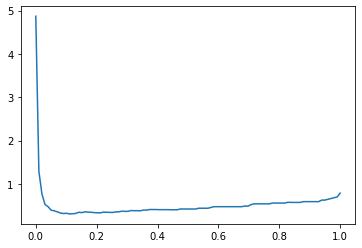

In [103]:

# Part 5
import matplotlib.pyplot as plt

x=[]
y=[]

for i in np.linspace(0,1,num=100):
    c=cost(model,i,X_test,Y_test)
    x.append(i)
    y.append(c)

plt.plot(x,y)
    
optimal_threshold = x[y.index(min(y))]
cost_at_optimal_threshold = min(y)
print(optimal_threshold,cost_at_optimal_threshold)

In [104]:
# Part 6
from Utils import epsilon_bounded

cost_at_optimal_threshold_validation = cost(model,0.11111111111111112,X_valid, Y_valid)
# Report the cost interval as a tuple cost_interval = (a,b)
eps_val=epsilon_bounded(len(X_valid),30, 0.05)
cost_interval = (cost_at_optimal_threshold_validation-eps_val, cost_at_optimal_threshold_validation+eps_val)
print(cost_interval,cost_at_optimal_threshold_validation)

# The code below will tell you if you filled in the intervals correctly
assert(type(cost_interval) == tuple)
assert(len(cost_interval) == 2)

(-0.4432477844798585, 1.097520219231378) 0.32713621737575976


In [107]:

# Part 7

variance_of_C = sum((x-cost_at_optimal_threshold_validation)**2 for x in Y_valid)/(len(Y_valid))
variance_of_C

0.11616499060679385

In [108]:

# Part 7
from Utils import bennett_epsilon

# A 95% confidence interval of the random variable C using Bennett's inequality
sigma_val=np.sqrt(variance_of_C)
eps_val=bennett_epsilon(len(X_valid), 30,sigma_val, 0.05 )
interval_of_C = (cost_at_optimal_threshold_validation-eps_val,cost_at_optimal_threshold_validation+eps_val)
print(interval_of_C)

assert(type(interval_of_C) == tuple)
assert(len(interval_of_C) == 2)



Numerical error 9.08995101411847e-16
(0.29895516517182014, 0.3553172695796994)
